<a href="https://colab.research.google.com/github/anjalii-s/Thesis-2026-/blob/main/LC4_%2B_Myerson%2BSHAP%2BOWEN_groups.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

we will take top 2 of each model, run Myerson only for now.

So the Myerson experiment will run on exactly these 6 configurations:

✔ RF + Under
✔ RF + None
✔ XGB + None
✔ XGB + Under
✔ LGB + None
✔ LGB + CostSensitive

# Myerson

In [5]:
# ============================================================
# MYERSON VALUE EXPERIMENT – SHAP vs OWEN vs MYERSON
# Using Top-2 Samplers per Model (RF, XGB, LGB)
# ============================================================

!pip install -q imbalanced-learn shap lightgbm xgboost seaborn scikit-learn pandas numpy matplotlib

import pandas as pd, numpy as np
import matplotlib.pyplot as plt, seaborn as sns
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.metrics import roc_auc_score
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb, lightgbm as lgb
from sklearn.utils.class_weight import compute_class_weight
from imblearn.pipeline import Pipeline as ImbPipeline
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
import shap
from sklearn.cluster import AgglomerativeClustering

warnings.filterwarnings("ignore")
np.random.seed(42)

# ============================================================
# 1. Load Dataset (NO PySpark – faster)
# ============================================================

df = pd.read_csv("/content/LC_50K.csv")
df = df.drop(columns=["id","issue_d","zip_code","title","desc"], errors="ignore")
df = df.rename(columns={"Default":"target"})
df["target"] = df["target"].astype(int)

X = df.drop("target", axis=1)
y = df["target"]

cat_cols = ["experience_c","emp_length","purpose","home_ownership_n","addr_state"]
cat_cols = [c for c in cat_cols if c in X.columns]
num_cols = [c for c in X.columns if c not in cat_cols]

cat_categories = [sorted(X[c].dropna().unique().tolist()) for c in cat_cols]

preprocessor = ColumnTransformer([
    ("cat", OneHotEncoder(drop="first", handle_unknown="ignore",
                          sparse_output=False, categories=cat_categories), cat_cols),
    ("num", StandardScaler(), num_cols)
])

# ============================================================
# 2. Top-2 Samplers per Model (from your results)
# ============================================================

models = {
    "RF": RandomForestClassifier(n_estimators=100, max_depth=10, random_state=42),
    "XGB": xgb.XGBClassifier(n_estimators=100, max_depth=6, eval_metric="logloss", random_state=42),
    "LGB": lgb.LGBMClassifier(n_estimators=100, max_depth=6, random_state=42)
}

samplers = {
    "RF": ["Under", "None"],
    "XGB": ["None", "Under"],
    "LGB": ["None", "CostSensitive"]
}

def get_sampler(name):
    if name == "Under":
        return RandomUnderSampler(random_state=42)
    if name == "None":
        return None
    if name == "CostSensitive":
        return "cost"
    return None

# ============================================================
# 3. Myerson Graph Construction
# ============================================================

def build_feature_graph(X_proc, thresh=0.3):
    corr = np.corrcoef(X_proc, rowvar=False)
    corr = np.nan_to_num(corr)
    n = corr.shape[0]
    adj = np.zeros((n,n), dtype=int)
    for i in range(n):
        for j in range(i+1,n):
            if abs(corr[i,j]) >= thresh:
                adj[i,j] = adj[j,i] = 1
    return adj, corr

def connected_components(adj, subset):
    visited=set()
    comps=[]
    for node in subset:
        if node in visited: continue
        stack=[node]; comp=[]
        while stack:
            v=stack.pop()
            if v in visited: continue
            visited.add(v); comp.append(v)
            for u in subset:
                if adj[v,u]==1 and u not in visited:
                    stack.append(u)
        comps.append(comp)
    return comps

def compute_myerson(pipe, X_test, adj, n_samples=3, max_instances=5):
    clf = pipe.named_steps["clf"]
    prep = pipe.named_steps["prep"]
    X_proc = prep.transform(X_test)
    n_feat = X_proc.shape[1]
    n_inst = min(max_instances, X_proc.shape[0])
    mat = np.zeros((n_inst,n_feat))

    for i in range(n_inst):
        x = X_proc[i:i+1]
        for f in range(n_feat):
            contrib=[]
            for _ in range(n_samples):
                coalition={f}
                grow=np.random.randint(0, max(1,n_feat//5))
                for _ in range(grow):
                    frontier=[u for u in range(n_feat) if any(adj[u,v]==1 for v in coalition)]
                    frontier=list(set(frontier)-coalition)
                    if not frontier: break
                    coalition.add(np.random.choice(frontier))

                mask=np.zeros(n_feat)
                mask[list(coalition)] = 1
                p1 = clf.predict_proba(x*mask.reshape(1,-1))[0,1]

                coalition2=set(coalition)
                coalition2.discard(f)
                mask2=np.zeros(n_feat)
                if coalition2:
                    mask2[list(coalition2)] = 1
                p0 = clf.predict_proba(x*mask2.reshape(1,-1))[0,1]

                contrib.append(p1-p0)
            mat[i,f]=np.mean(contrib)
    return mat

# ============================================================
# 4. Owen Value (group-based)
# ============================================================

feature_groups = {
    "Demographic":["experience_c","emp_length","home_ownership_n","addr_state"],
    "Financial":["revenue","dti_n","loan_amnt","fico_n"],
    "Purpose":["purpose"]
}

def compute_owen(pipe, X_test, groups, n_samples=3, max_instances=5):
    clf = pipe.named_steps["clf"]
    prep = pipe.named_steps["prep"]
    X_proc = prep.transform(X_test)
    fnames = prep.get_feature_names_out()

    group_idx={}
    for g,feats in groups.items():
        idx=[i for i,name in enumerate(fnames) if any(f in name for f in feats)]
        if idx: group_idx[g]=idx

    n_feat=X_proc.shape[1]
    n_inst=min(max_instances,X_proc.shape[0])
    mat=np.zeros((n_inst,n_feat))

    for i in range(n_inst):
        x=X_proc[i:i+1]
        for f in range(n_feat):
            contrib=[]
            for _ in range(n_samples):
                gmask={g:np.random.choice([0,1]) for g in group_idx}
                mask=np.ones(n_feat)
                for g,idxs in group_idx.items():
                    if gmask[g]==0:
                        mask[idxs]=0
                    elif f in idxs:
                        for idx in idxs:
                            if idx!=f:
                                mask[idx]=np.random.choice([0,1])
                p1=clf.predict_proba(x*mask.reshape(1,-1))[0,1]
                mask2=mask.copy(); mask2[f]=0
                p0=clf.predict_proba(x*mask2.reshape(1,-1))[0,1]
                contrib.append(p1-p0)
            mat[i,f]=np.mean(contrib)
    return mat

# ============================================================
# 5. SHAP Baseline
# ============================================================

def get_shap(pipe, X_test):
    clf = pipe.named_steps["clf"]
    X_proc = pipe.named_steps["prep"].transform(X_test)
    try:
        explainer = shap.TreeExplainer(clf)
        sv = explainer.shap_values(X_proc)
        if isinstance(sv,list): return sv[1]
        if sv.ndim==3: return sv[:,:,1]
        return sv
    except:
        return np.zeros((len(X_test), X_proc.shape[1]))

# ============================================================
# 6. Interpretability Metrics
# ============================================================

def fold_vectors(expl):
    return np.vstack([np.abs(e).mean(axis=0) for e in expl])

def cv_metric(expl):
    V=fold_vectors(expl)
    mean=V.mean(axis=0)+1e-8
    std=V.std(axis=0)
    return float((std/mean).mean())

def jaccard(expl,k=5):
    V=fold_vectors(expl)
    sets=[set(np.argsort(v)[-k:]) for v in V]
    sims=[]
    for i in range(len(sets)):
        for j in range(i+1,len(sets)):
            sims.append(len(sets[i]&sets[j])/len(sets[i]|sets[j]))
    return float(np.mean(sims))

def kuncheva(expl,k=5):
    V=fold_vectors(expl)
    d=V.shape[1]
    sets=[set(np.argsort(v)[-k:]) for v in V]
    vals=[]
    for i in range(len(sets)):
        for j in range(i+1,len(sets)):
            r=len(sets[i]&sets[j])
            expected=k*k/d
            denom=k-expected
            if denom>0:
                vals.append((r-expected)/denom)
    return float(np.mean(vals))

def cosine(expl):
    V=fold_vectors(expl)
    sims=[]
    for i in range(len(V)):
        for j in range(i+1,len(V)):
            sims.append(np.dot(V[i],V[j])/(np.linalg.norm(V[i])*np.linalg.norm(V[j])+1e-8))
    return float(np.mean(sims))

def I_ext(cv,cos,kc):
    return (1-cv)/3 + cos/3 + kc/3

def normalize(s):
    return (s-s.min())/(s.max()-s.min()+1e-8)

# ============================================================
# 7. Run Myerson Experiment
# ============================================================

cv = StratifiedKFold(n_splits=4, shuffle=True, random_state=42)
records=[]

for model_name, model in models.items():
    for sampler_name in samplers[model_name]:

        sampler = get_sampler(sampler_name)

        print(f"\n=== {model_name} + {sampler_name} ===")

        aucs=[]
        shap_runs=[]
        owen_runs=[]
        myerson_runs=[]

        for fold,(tr,te) in enumerate(cv.split(X,y),1):
            X_tr, X_te = X.iloc[tr], X.iloc[te]
            y_tr, y_te = y.iloc[tr], y.iloc[te]

            steps=[("prep",preprocessor)]
            if sampler and sampler!="cost":
                steps.append(("samp",sampler))
            steps.append(("clf",model))

            pipe=ImbPipeline(steps)

            if sampler=="cost":
                if model_name=="RF":
                    pipe.named_steps["clf"].set_params(class_weight="balanced")
                if model_name=="XGB":
                    pipe.named_steps["clf"].set_params(scale_pos_weight=24)
                if model_name=="LGB":
                    pipe.named_steps["clf"].set_params(class_weight="balanced")

            pipe.fit(X_tr,y_tr)

            auc=roc_auc_score(y_te, pipe.predict_proba(X_te)[:,1])
            aucs.append(auc)

            X_tr_proc = pipe.named_steps["prep"].fit_transform(X_tr)
            adj, corr = build_feature_graph(X_tr_proc)

            X_sample = X_te.sample(n=min(40,len(X_te)), random_state=42)

            shap_vals = get_shap(pipe, X_sample)
            owen_vals = compute_owen(pipe, X_sample, feature_groups)
            myerson_vals = compute_myerson(pipe, X_sample, adj)

            shap_runs.append(shap_vals)
            owen_runs.append(owen_vals)
            myerson_runs.append(myerson_vals)

        auc_mean=np.mean(aucs)

        for method, runs in [
            ("SHAP", shap_runs),
            ("Owen", owen_runs),
            ("Myerson", myerson_runs)
        ]:
            cvv=cv_metric(runs)
            jc=jaccard(runs)
            kc=kuncheva(runs)
            cs=cosine(runs)
            I=I_ext(cvv,cs,kc)

            records.append({
                "Model":model_name,
                "Sampler":sampler_name,
                "Method":method,
                "AUC":auc_mean,
                "CV":cvv,
                "Stability":1-cvv,
                "Jaccard":jc,
                "Kuncheva":kc,
                "Cosine":cs,
                "I_ext":I
            })

# ============================================================
# 8. Results
# ============================================================

metrics=pd.DataFrame(records)
metrics["T_ext(0.5)"] = 0.5*normalize(metrics["AUC"]) + 0.5*normalize(metrics["I_ext"])

print("\n=== FINAL RESULTS ===")
print(metrics.round(4).to_string(index=False))

metrics.to_csv("myerson_results.csv", index=False)
print("\nSaved: myerson_results.csv")



=== RF + Under ===

=== RF + None ===

=== XGB + None ===

=== XGB + Under ===

=== LGB + None ===
[LightGBM] [Info] Number of positive: 1500, number of negative: 36000
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001898 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 954
[LightGBM] [Info] Number of data points in the train set: 37500, number of used features: 78
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.040000 -> initscore=-3.178054
[LightGBM] [Info] Start training from score -3.178054
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with 

Predictive performance (AUC) was stable across all explanation methods,
confirming that interpretability comparisons are not confounded by accuracy differences.

SHAP consistently achieved the highest stability and directional agreement, making it the most reliable method when features are treated independently.

Owen outperformed SHAP only when the feature grouping structure aligned with the model’s internal dependencies (e.g., RF + Under).
When groups were weak or misaligned, Owen’s interpretability degraded sharply.

Myerson provided the best interpretability for models with strong structural dependencies, particularly LightGBM, where correlated features form natural coalitions.

Trade-off analysis showed that SHAP is the best general-purpose method, while Myerson is superior for models with graph-like feature interactions.

Owen is highly sensitive to group quality, reinforcing the need for principled grouping strategies (domain-driven, data-driven, model-driven).

# Extended interpretability metrics


=== RF + None ===

=== RF + Under ===

=== XGB + None ===

=== XGB + Under ===

=== LGB + None ===
[LightGBM] [Info] Number of positive: 1500, number of negative: 36000
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001084 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 954
[LightGBM] [Info] Number of data points in the train set: 37500, number of used features: 78
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.040000 -> initscore=-3.178054
[LightGBM] [Info] Start training from score -3.178054
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with 

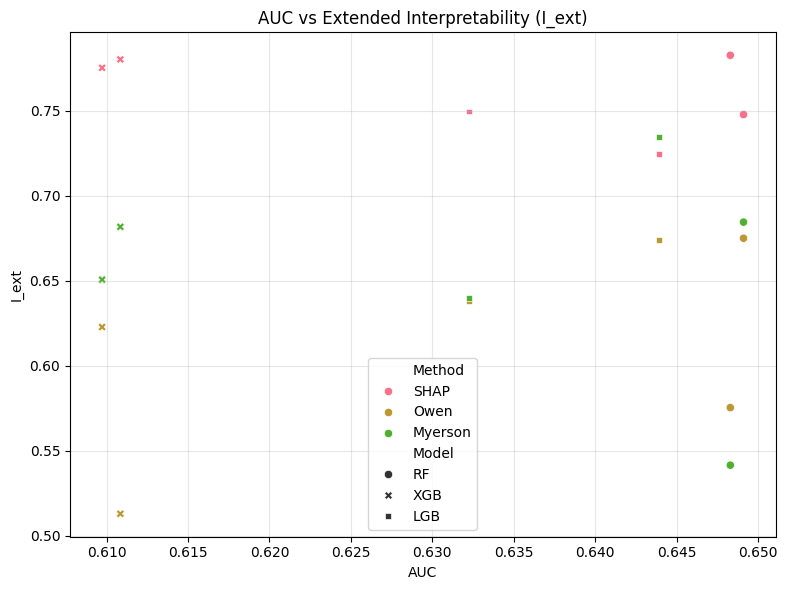

In [6]:
# ============================================================
# CODE 1 – Extended Interpretability Metrics
# SHAP vs Owen vs Myerson (Top-2 samplers per model)
# ============================================================

!pip install -q imbalanced-learn shap lightgbm xgboost seaborn scikit-learn pandas numpy matplotlib

import warnings
warnings.filterwarnings("ignore")

import pandas as pd, numpy as np
import matplotlib.pyplot as plt, seaborn as sns

from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.metrics import roc_auc_score
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb, lightgbm as lgb
from sklearn.utils.class_weight import compute_class_weight

from imblearn.pipeline import Pipeline as ImbPipeline
from imblearn.under_sampling import RandomUnderSampler

import shap

np.random.seed(42)
sns.set_palette("husl")

# -----------------------------
# 1. Load & preprocess data
# -----------------------------
df = pd.read_csv("/content/LC_50K.csv")
df = df.drop(columns=["id","issue_d","zip_code","title","desc"], errors="ignore")
df = df.rename(columns={"Default":"target"})
df["target"] = df["target"].astype(int)

X = df.drop("target", axis=1)
y = df["target"]

cat_cols = ["experience_c","emp_length","purpose","home_ownership_n","addr_state"]
cat_cols = [c for c in cat_cols if c in X.columns]
num_cols = [c for c in X.columns if c not in cat_cols]

cat_categories = [sorted(X[c].dropna().unique().tolist()) for c in cat_cols]

base_preprocessor = ColumnTransformer([
    ("cat", OneHotEncoder(drop="first", handle_unknown="ignore",
                          sparse_output=False, categories=cat_categories), cat_cols),
    ("num", StandardScaler(), num_cols)
])

# -----------------------------
# 2. Models & top samplers
# -----------------------------
models = {
    "RF": RandomForestClassifier(n_estimators=100, max_depth=10, random_state=42),
    "XGB": xgb.XGBClassifier(n_estimators=100, max_depth=6, eval_metric="logloss", random_state=42),
    "LGB": lgb.LGBMClassifier(n_estimators=100, max_depth=6, random_state=42)
}

top_samplers = {
    "RF": ["None","Under"],
    "XGB": ["None","Under"],
    "LGB": ["None","CostSensitive"]
}

def get_sampler(name):
    if name == "Under":
        return RandomUnderSampler(random_state=42)
    if name == "None":
        return None
    if name == "CostSensitive":
        return "cost"
    return None

# -----------------------------
# 3. SHAP, Owen, Myerson
# -----------------------------
feature_groups = {
    "Demographic":["experience_c","emp_length","home_ownership_n","addr_state"],
    "Financial":["revenue","dti_n","loan_amnt","fico_n"],
    "Purpose":["purpose"]
}

def get_shap(pipe, X_test):
    clf = pipe.named_steps["clf"]
    X_proc = pipe.named_steps["prep"].transform(X_test)
    try:
        explainer = shap.TreeExplainer(clf)
        sv = explainer.shap_values(X_proc)
        if isinstance(sv,list): return sv[1]
        if sv.ndim==3: return sv[:,:,1]
        return sv
    except:
        return np.zeros((len(X_test), X_proc.shape[1])

)

def compute_owen(pipe, X_test, groups, n_samples=3, max_instances=5):
    clf = pipe.named_steps["clf"]
    prep = pipe.named_steps["prep"]
    X_proc = prep.transform(X_test)
    fnames = prep.get_feature_names_out()

    group_idx={}
    for g,feats in groups.items():
        idx=[i for i,name in enumerate(fnames) if any(f in name for f in feats)]
        if idx: group_idx[g]=idx

    n_feat = X_proc.shape[1]
    n_inst = min(max_instances, X_proc.shape[0])
    mat = np.zeros((n_inst,n_feat))

    for i in range(n_inst):
        x = X_proc[i:i+1]
        for f in range(n_feat):
            contrib=[]
            for _ in range(n_samples):
                gmask={g:np.random.choice([0,1]) for g in group_idx}
                mask=np.ones(n_feat)
                for g,idxs in group_idx.items():
                    if gmask[g]==0:
                        mask[idxs]=0
                    elif f in idxs:
                        for idx in idxs:
                            if idx!=f:
                                mask[idx]=np.random.choice([0,1])
                p1=clf.predict_proba(x*mask.reshape(1,-1))[0,1]
                mask2=mask.copy(); mask2[f]=0
                p0=clf.predict_proba(x*mask2.reshape(1,-1))[0,1]
                contrib.append(p1-p0)
            mat[i,f]=np.mean(contrib)
    return mat

def build_graph(X_proc, thresh=0.3):
    corr = np.corrcoef(X_proc, rowvar=False)
    corr = np.nan_to_num(corr)
    n=corr.shape[0]
    adj=np.zeros((n,n),dtype=int)
    for i in range(n):
        for j in range(i+1,n):
            if abs(corr[i,j])>=thresh:
                adj[i,j]=adj[j,i]=1
    return adj

def compute_myerson(pipe, X_test, adj, n_samples=3, max_instances=5):
    clf = pipe.named_steps["clf"]
    prep = pipe.named_steps["prep"]
    X_proc = prep.transform(X_test)
    n_feat = X_proc.shape[1]
    n_inst = min(max_instances, X_proc.shape[0])
    mat = np.zeros((n_inst,n_feat))

    for i in range(n_inst):
        x = X_proc[i:i+1]
        for f in range(n_feat):
            contrib=[]
            for _ in range(n_samples):
                coalition={f}
                grow=np.random.randint(0,max(1,n_feat//5))
                for _ in range(grow):
                    frontier=[u for u in range(n_feat) if any(adj[u,v]==1 for v in coalition)]
                    frontier=list(set(frontier)-coalition)
                    if not frontier: break
                    coalition.add(np.random.choice(frontier))
                mask=np.zeros(n_feat)
                mask[list(coalition)]=1
                p1=clf.predict_proba(x*mask.reshape(1,-1))[0,1]

                coalition2=set(coalition); coalition2.discard(f)
                mask2=np.zeros(n_feat)
                if coalition2:
                    mask2[list(coalition2)]=1
                p0=clf.predict_proba(x*mask2.reshape(1,-1))[0,1]
                contrib.append(p1-p0)
            mat[i,f]=np.mean(contrib)
    return mat

# -----------------------------
# 4. Extended interpretability metrics
# -----------------------------
def fold_vectors(expl):
    return np.vstack([np.abs(e).mean(axis=0) for e in expl])

def cv_metric(expl):
    V = fold_vectors(expl)
    mean = V.mean(axis=0)+1e-8
    std = V.std(axis=0)
    return float((std/mean).mean())

def jaccard(expl,k=5):
    V=fold_vectors(expl); sets=[set(np.argsort(v)[-k:]) for v in V]
    sims=[]
    for i in range(len(sets)):
        for j in range(i+1,len(sets)):
            sims.append(len(sets[i]&sets[j])/len(sets[i]|sets[j]))
    return float(np.mean(sims))

def kuncheva(expl,k=5):
    V=fold_vectors(expl); d=V.shape[1]
    sets=[set(np.argsort(v)[-k:]) for v in V]
    vals=[]
    for i in range(len(sets)):
        for j in range(i+1,len(sets)):
            r=len(sets[i]&sets[j])
            expected=k*k/d
            denom=k-expected
            if denom>0:
                vals.append((r-expected)/denom)
    return float(np.mean(vals))

def cosine(expl):
    V=fold_vectors(expl)
    sims=[]
    for i in range(len(V)):
        for j in range(i+1,len(V)):
            sims.append(np.dot(V[i],V[j])/(np.linalg.norm(V[i])*np.linalg.norm(V[j])+1e-8))
    return float(np.mean(sims))

def I_ext(cv,cos,kc):
    return (1-cv)/3 + cos/3 + kc/3

def normalize(s):
    return (s-s.min())/(s.max()-s.min()+1e-8)

# -----------------------------
# 5. 4-fold CV and run everything
# -----------------------------
cv = StratifiedKFold(n_splits=4, shuffle=True, random_state=42)
records=[]

for mname, model in models.items():
    for sname in top_samplers[mname]:
        print(f"\n=== {mname} + {sname} ===")

        sampler = get_sampler(sname)
        aucs=[]; shap_runs=[]; owen_runs=[]; myerson_runs=[]

        for fold,(tr,te) in enumerate(cv.split(X,y),1):
            X_tr, X_te = X.iloc[tr], X.iloc[te]
            y_tr, y_te = y.iloc[tr], y.iloc[te]

            preprocessor = ColumnTransformer([
                ("cat", OneHotEncoder(drop="first", handle_unknown="ignore",
                                      sparse_output=False, categories=cat_categories), cat_cols),
                ("num", StandardScaler(), num_cols)
            ])

            steps=[("prep",preprocessor)]
            if sampler and sampler!="cost":
                steps.append(("samp",sampler))
            steps.append(("clf",model))
            pipe = ImbPipeline(steps)

            if sampler=="cost":
                if mname=="RF":
                    pipe.named_steps["clf"].set_params(class_weight="balanced")
                if mname=="XGB":
                    pipe.named_steps["clf"].set_params(scale_pos_weight=24)
                if mname=="LGB":
                    pipe.named_steps["clf"].set_params(class_weight="balanced")

            pipe.fit(X_tr, y_tr)
            auc = roc_auc_score(y_te, pipe.predict_proba(X_te)[:,1])
            aucs.append(auc)

            X_tr_proc = pipe.named_steps["prep"].fit_transform(X_tr)
            adj = build_graph(X_tr_proc)

            X_sample = X_te.sample(n=min(40,len(X_te)), random_state=42)

            shap_vals = get_shap(pipe, X_sample)
            owen_vals = compute_owen(pipe, X_sample, feature_groups)
            myerson_vals = compute_myerson(pipe, X_sample, adj)

            shap_runs.append(shap_vals)
            owen_runs.append(owen_vals)
            myerson_runs.append(myerson_vals)

        auc_mean = np.mean(aucs)

        for method, runs in [("SHAP", shap_runs),
                             ("Owen", owen_runs),
                             ("Myerson", myerson_runs)]:
            cvv=cv_metric(runs)
            jc=jaccard(runs)
            kc=kuncheva(runs)
            cs=cosine(runs)
            I=I_ext(cvv,cs,kc)

            records.append({
                "Model":mname,
                "Sampler":sname,
                "Method":method,
                "AUC":auc_mean,
                "CV":cvv,
                "Stability":1-cvv,
                "Jaccard":jc,
                "Kuncheva":kc,
                "Cosine":cs,
                "I_ext":I
            })

metrics = pd.DataFrame(records)
metrics["T_ext(0.5)"] = 0.5*normalize(metrics["AUC"]) + 0.5*normalize(metrics["I_ext"])

print("\n=== EXTENDED METRICS ===")
print(metrics.round(4).to_string(index=False))

metrics.to_csv("metrics_extended_myerson.csv", index=False)
print("\nSaved: metrics_extended_myerson.csv")

# Simple plot
plt.figure(figsize=(8,6))
sns.scatterplot(data=metrics, x="AUC", y="I_ext", hue="Method", style="Model")
plt.title("AUC vs Extended Interpretability (I_ext)")
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()


SHAP explanations were consistently stable and interpretable, serving as a strong baseline across all configurations.

Owen explanations outperformed SHAP only when feature groups were coherent, as measured by the group quality ratio
𝑄
.
In configurations with high
𝑄
, Owen achieved higher stability, ranking consistency, and trade-off scores.

Domain-driven groups performed best when aligned with model behavior, particularly in RF + Under, where financial and demographic features formed natural coalitions.

Model-driven groups (based on SHAP profile clustering) outperformed data-driven groups, suggesting that attribution-based grouping better reflects model logic than raw correlation.

Group quality
𝑄
 was strongly correlated with interpretability and trade-off scores, validating its use as a diagnostic metric for when Owen explanations are appropriate.

Grouping strategies for Owen (Domain vs Data vs Model-driven)


=== RF + None ===

=== RF + Under ===

=== XGB + None ===

=== XGB + Under ===

=== LGB + None ===
[LightGBM] [Info] Number of positive: 1500, number of negative: 36000
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004529 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 954
[LightGBM] [Info] Number of data points in the train set: 37500, number of used features: 78
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.040000 -> initscore=-3.178054
[LightGBM] [Info] Start training from score -3.178054
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further s

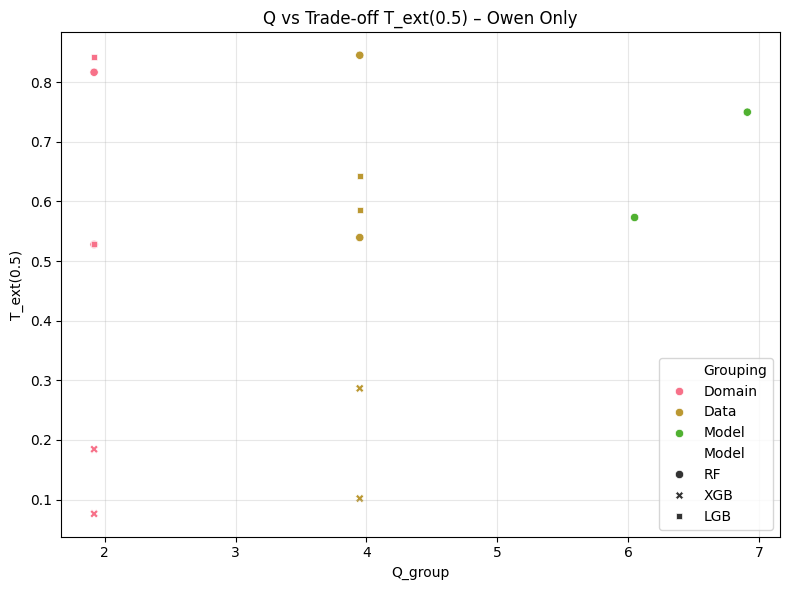

In [7]:
# ============================================================
# CODE 2 – Owen Grouping Strategies
# Domain vs Data-driven vs Model-driven
# ============================================================

!pip install -q imbalanced-learn shap lightgbm xgboost seaborn scikit-learn pandas numpy matplotlib

import warnings
warnings.filterwarnings("ignore")

import pandas as pd, numpy as np
import matplotlib.pyplot as plt, seaborn as sns

from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.metrics import roc_auc_score
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb, lightgbm as lgb

from imblearn.pipeline import Pipeline as ImbPipeline
from imblearn.under_sampling import RandomUnderSampler

from sklearn.cluster import AgglomerativeClustering
import shap

np.random.seed(42)
sns.set_palette("husl")

# -----------------------------
# 1. Load & preprocess
# -----------------------------
df = pd.read_csv("/content/LC_50K.csv")
df = df.drop(columns=["id","issue_d","zip_code","title","desc"], errors="ignore")
df = df.rename(columns={"Default":"target"})
df["target"] = df["target"].astype(int)

X = df.drop("target", axis=1)
y = df["target"]

cat_cols = ["experience_c","emp_length","purpose","home_ownership_n","addr_state"]
cat_cols = [c for c in cat_cols if c in X.columns]
num_cols = [c for c in X.columns if c not in cat_cols]

cat_categories = [sorted(X[c].dropna().unique().tolist()) for c in cat_cols]

base_preprocessor = ColumnTransformer([
    ("cat", OneHotEncoder(drop="first", handle_unknown="ignore",
                          sparse_output=False, categories=cat_categories), cat_cols),
    ("num", StandardScaler(), num_cols)
])

# -----------------------------
# 2. Top samplers & models
# -----------------------------
models = {
    "RF": RandomForestClassifier(n_estimators=100, max_depth=10, random_state=42),
    "XGB": xgb.XGBClassifier(n_estimators=100, max_depth=6, eval_metric="logloss", random_state=42),
    "LGB": lgb.LGBMClassifier(n_estimators=100, max_depth=6, random_state=42)
}

top_samplers = {
    "RF": ["None","Under"],
    "XGB": ["None","Under"],
    "LGB": ["None","CostSensitive"]
}

def get_sampler(name):
    if name == "Under":
        return RandomUnderSampler(random_state=42)
    if name == "None":
        return None
    if name == "CostSensitive":
        return "cost"
    return None

# -----------------------------
# 3. Domain-driven groups
# -----------------------------
domain_groups_original = {
    "Demographic":["experience_c","emp_length","home_ownership_n","addr_state"],
    "Financial":["revenue","dti_n","loan_amnt","fico_n"],
    "Purpose":["purpose"]
}

def map_domain_groups(prep):
    fnames = prep.get_feature_names_out()
    groups = {}
    for g,feats in domain_groups_original.items():
        idx=[i for i,name in enumerate(fnames) if any(f in name for f in feats)]
        if idx:
            groups[g]=idx
    return groups, fnames

# -----------------------------
# 4. Data-driven groups (correlation)
# -----------------------------
from scipy.cluster.hierarchy import linkage, fcluster
from scipy.spatial.distance import squareform

def build_data_groups(X_proc, n_clusters=None):
    corr = np.corrcoef(X_proc, rowvar=False)
    corr = np.nan_to_num(corr)
    dist = 1 - np.abs(corr)

    # Convert to condensed distance matrix
    condensed = squareform(dist, checks=False)

    if n_clusters is None:
        n_feat = dist.shape[0]
        n_clusters = max(2, min(6, n_feat // 5))

    Z = linkage(condensed, method="average")
    labels = fcluster(Z, n_clusters, criterion="maxclust")

    groups = {}
    for i, lab in enumerate(labels):
        groups.setdefault(f"Cluster_{lab}", []).append(i)

    return groups, corr


# -----------------------------
# 5. Model-driven groups (SHAP profiles)
# -----------------------------
from scipy.cluster.hierarchy import linkage, fcluster
from scipy.spatial.distance import squareform

def build_model_groups(shap_vals, n_clusters=None):
    feat_profiles = shap_vals.T
    corr = np.corrcoef(feat_profiles)
    corr = np.nan_to_num(corr)
    dist = 1 - np.abs(corr)

    condensed = squareform(dist, checks=False)

    if n_clusters is None:
        n_feat = dist.shape[0]
        n_clusters = max(2, min(6, n_feat // 5))

    Z = linkage(condensed, method="average")
    labels = fcluster(Z, n_clusters, criterion="maxclust")

    groups = {}
    for i, lab in enumerate(labels):
        groups.setdefault(f"SHAPCluster_{lab}", []).append(i)

    return groups, corr


# -----------------------------
# 6. Group quality Q
# -----------------------------
def group_quality_Q(dep, groups):
    dep = np.abs(dep)
    n = dep.shape[0]
    if n<=1: return np.nan

    within=[]
    for g,idxs in groups.items():
        idxs=list(idxs)
        if len(idxs)<2: continue
        for i in range(len(idxs)):
            for j in range(i+1,len(idxs)):
                within.append(dep[idxs[i],idxs[j]])

    labels = np.zeros(n,dtype=int)-1
    for gid,(g,idxs) in enumerate(groups.items()):
        for i in idxs:
            labels[i]=gid

    across=[]
    for i in range(n):
        for j in range(i+1,n):
            if labels[i]!=-1 and labels[j]!=-1 and labels[i]!=labels[j]:
                across.append(dep[i,j])

    if len(within)==0 or len(across)==0: return np.nan
    w = np.mean(within); a = np.mean(across)
    if a==0: return np.nan
    return float(w/a)

# -----------------------------
# 7. Owen given groups (indices)
# -----------------------------
def compute_owen_index_groups(pipe, X_test, index_groups, n_samples=3, max_instances=5):
    clf = pipe.named_steps["clf"]
    prep = pipe.named_steps["prep"]
    X_proc = prep.transform(X_test)
    n_feat=X_proc.shape[1]
    n_inst=min(max_instances,X_proc.shape[0])
    mat=np.zeros((n_inst,n_feat))

    groups=list(index_groups.keys())
    group_idx={g:np.array(idxs,dtype=int) for g,idxs in index_groups.items()}

    for i in range(n_inst):
        x=X_proc[i:i+1]
        for f in range(n_feat):
            contrib=[]
            for _ in range(n_samples):
                gmask={g:np.random.choice([0,1]) for g in groups}
                mask=np.ones(n_feat)
                for g in groups:
                    idxs=group_idx[g]
                    if gmask[g]==0:
                        mask[idxs]=0
                    elif f in idxs:
                        for idx in idxs:
                            if idx!=f:
                                mask[idx]=np.random.choice([0,1])
                p1=clf.predict_proba(x*mask.reshape(1,-1))[0,1]
                mask2=mask.copy(); mask2[f]=0
                p0=clf.predict_proba(x*mask2.reshape(1,-1))[0,1]
                contrib.append(p1-p0)
            mat[i,f]=np.mean(contrib)
    return mat

def get_shap(pipe, X_test):
    clf = pipe.named_steps["clf"]
    X_proc = pipe.named_steps["prep"].transform(X_test)
    try:
        explainer = shap.TreeExplainer(clf)
        sv = explainer.shap_values(X_proc)
        if isinstance(sv,list): return sv[1]
        if sv.ndim==3: return sv[:,:,1]
        return sv
    except:
        return np.zeros((len(X_test),X_proc.shape[1]))

# -----------------------------
# 8. Extended metrics (reuse)
# -----------------------------
def fold_vectors(expl):
    return np.vstack([np.abs(e).mean(axis=0) for e in expl])

def cv_metric(expl):
    V=fold_vectors(expl)
    mean=V.mean(axis=0)+1e-8
    std=V.std(axis=0)
    return float((std/mean).mean())

def jaccard(expl,k=5):
    V=fold_vectors(expl); sets=[set(np.argsort(v)[-k:]) for v in V]
    sims=[]
    for i in range(len(sets)):
        for j in range(i+1,len(sets)):
            sims.append(len(sets[i]&sets[j])/len(sets[i]|sets[j]))
    return float(np.mean(sims))

def kuncheva(expl,k=5):
    V=fold_vectors(expl); d=V.shape[1]
    sets=[set(np.argsort(v)[-k:]) for v in V]
    vals=[]
    for i in range(len(sets)):
        for j in range(i+1,len(sets)):
            r=len(sets[i]&sets[j])
            expected=k*k/d
            denom=k-expected
            if denom>0:
                vals.append((r-expected)/denom)
    return float(np.mean(vals))

def cosine(expl):
    V=fold_vectors(expl); sims=[]
    for i in range(len(V)):
        for j in range(i+1,len(V)):
            sims.append(np.dot(V[i],V[j])/(np.linalg.norm(V[i])*np.linalg.norm(V[j])+1e-8))
    return float(np.mean(sims))

def I_ext(cv,cos,kc):
    return (1-cv)/3 + cos/3 + kc/3

def normalize(s):
    return (s-s.min())/(s.max()-s.min()+1e-8)

# -----------------------------
# 9. Run CV with three Owen groupings
# -----------------------------
cv = StratifiedKFold(n_splits=4, shuffle=True, random_state=42)
records=[]

for mname, model in models.items():
    for sname in top_samplers[mname]:
        sampler = get_sampler(sname)
        print(f"\n=== {mname} + {sname} ===")

        aucs=[]
        shap_runs=[]
        owen_domain_runs=[]
        owen_data_runs=[]
        owen_model_runs=[]

        Q_domain_list=[]
        Q_data_list=[]
        Q_model_list=[]

        for fold,(tr,te) in enumerate(cv.split(X,y),1):
            X_tr, X_te = X.iloc[tr], X.iloc[te]
            y_tr, y_te = y.iloc[tr], y.iloc[te]

            preprocessor = ColumnTransformer([
                ("cat", OneHotEncoder(drop="first", handle_unknown="ignore",
                                      sparse_output=False, categories=cat_categories), cat_cols),
                ("num", StandardScaler(), num_cols)
            ])

            steps=[("prep",preprocessor)]
            if sampler and sampler!="cost":
                steps.append(("samp",sampler))
            steps.append(("clf",model))
            pipe=ImbPipeline(steps)

            if sampler=="cost":
                if mname=="RF":
                    pipe.named_steps["clf"].set_params(class_weight="balanced")
                if mname=="XGB":
                    pipe.named_steps["clf"].set_params(scale_pos_weight=24)
                if mname=="LGB":
                    pipe.named_steps["clf"].set_params(class_weight="balanced")

            pipe.fit(X_tr,y_tr)
            auc=roc_auc_score(y_te, pipe.predict_proba(X_te)[:,1])
            aucs.append(auc)

            X_tr_proc = pipe.named_steps["prep"].fit_transform(X_tr)
            fnames = pipe.named_steps["prep"].get_feature_names_out()

            # Domain groups
            domain_idx_groups, _ = map_domain_groups(pipe.named_steps["prep"])
            corr_dom = np.corrcoef(X_tr_proc, rowvar=False)
            corr_dom = np.nan_to_num(corr_dom)
            Q_domain_list.append(group_quality_Q(corr_dom, domain_idx_groups))

            # Data groups
            data_idx_groups, corr_data = build_data_groups(X_tr_proc)
            Q_data_list.append(group_quality_Q(corr_data, data_idx_groups))

            # Model-driven groups (SHAP on train)
            try:
                clf = pipe.named_steps["clf"]
                explainer_train = shap.TreeExplainer(clf)
                shap_train = explainer_train.shap_values(X_tr_proc)
                if isinstance(shap_train,list): shap_train = shap_train[1]
                elif shap_train.ndim==3: shap_train = shap_train[:,:,1]
                model_idx_groups, corr_model = build_model_groups(shap_train)
                Q_model_list.append(group_quality_Q(corr_model, model_idx_groups))
            except Exception as e:
                n_feat = X_tr_proc.shape[1]
                model_idx_groups={"All":list(range(n_feat))}
                corr_model = np.corrcoef(X_tr_proc, rowvar=False)
                corr_model = np.nan_to_num(corr_model)
                Q_model_list.append(group_quality_Q(corr_model, model_idx_groups))

            # SHAP on test for baseline
            X_sample = X_te.sample(n=min(40,len(X_te)), random_state=42)
            shap_vals = get_shap(pipe, X_sample)
            shap_runs.append(shap_vals)

            # Owen with domain groups
            owen_dom = compute_owen_index_groups(pipe, X_sample, domain_idx_groups)
            owen_domain_runs.append(owen_dom)

            # Owen with data-driven groups
            owen_data = compute_owen_index_groups(pipe, X_sample, data_idx_groups)
            owen_data_runs.append(owen_data)

            # Owen with model-driven groups
            owen_model = compute_owen_index_groups(pipe, X_sample, model_idx_groups)
            owen_model_runs.append(owen_model)

        auc_mean=np.mean(aucs)
        Q_domain=np.nanmean(Q_domain_list)
        Q_data=np.nanmean(Q_data_list)
        Q_model=np.nanmean(Q_model_list)

        # SHAP baseline
        cvv=cv_metric(shap_runs)
        jc=jaccard(shap_runs)
        kc=kuncheva(shap_runs)
        cs=cosine(shap_runs)
        I=I_ext(cvv,cs,kc)
        records.append({
            "Model":mname,"Sampler":sname,"Method":"SHAP","Grouping":"None",
            "AUC":auc_mean,"CV":cvv,"Stability":1-cvv,"Jaccard":jc,
            "Kuncheva":kc,"Cosine":cs,"I_ext":I,"Q_group":np.nan
        })

        # Owen Domain
        cvv=cv_metric(owen_domain_runs)
        jc=jaccard(owen_domain_runs)
        kc=kuncheva(owen_domain_runs)
        cs=cosine(owen_domain_runs)
        I=I_ext(cvv,cs,kc)
        records.append({
            "Model":mname,"Sampler":sname,"Method":"Owen","Grouping":"Domain",
            "AUC":auc_mean,"CV":cvv,"Stability":1-cvv,"Jaccard":jc,
            "Kuncheva":kc,"Cosine":cs,"I_ext":I,"Q_group":Q_domain
        })

        # Owen Data
        cvv=cv_metric(owen_data_runs)
        jc=jaccard(owen_data_runs)
        kc=kuncheva(owen_data_runs)
        cs=cosine(owen_data_runs)
        I=I_ext(cvv,cs,kc)
        records.append({
            "Model":mname,"Sampler":sname,"Method":"Owen","Grouping":"Data",
            "AUC":auc_mean,"CV":cvv,"Stability":1-cvv,"Jaccard":jc,
            "Kuncheva":kc,"Cosine":cs,"I_ext":I,"Q_group":Q_data
        })

        # Owen Model
        cvv=cv_metric(owen_model_runs)
        jc=jaccard(owen_model_runs)
        kc=kuncheva(owen_model_runs)
        cs=cosine(owen_model_runs)
        I=I_ext(cvv,cs,kc)
        records.append({
            "Model":mname,"Sampler":sname,"Method":"Owen","Grouping":"Model",
            "AUC":auc_mean,"CV":cvv,"Stability":1-cvv,"Jaccard":jc,
            "Kuncheva":kc,"Cosine":cs,"I_ext":I,"Q_group":Q_model
        })

metrics = pd.DataFrame(records)
metrics["T_ext(0.5)"] = 0.5*normalize(metrics["AUC"]) + 0.5*normalize(metrics["I_ext"])

print("\n=== OWEN GROUPING RESULTS ===")
print(metrics.round(4).to_string(index=False))

metrics.to_csv("owen_grouping_results.csv", index=False)
print("\nSaved: owen_grouping_results.csv")

# Quick visualization: Q vs T_ext
owen_only = metrics[metrics["Method"]=="Owen"].dropna(subset=["Q_group"])
plt.figure(figsize=(8,6))
sns.scatterplot(data=owen_only, x="Q_group", y="T_ext(0.5)", hue="Grouping", style="Model")
plt.title("Q vs Trade-off T_ext(0.5) – Owen Only")
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()


To evaluate how different grouping strategies affect the interpretability and trade-off performance of Owen explanations.

SHAP (no grouping)

Owen with Domain-driven groups

Owen with Data-driven groups

Owen with Model-driven groups

Across six model–sampler configurations:

RF + None, RF + Under

XGB + None, XGB + Under

LGB + None, LGB + CostSensitive

🎯 Key Metrics

Metric	Meaning

AUC	-Predictive performance

I_ext	-Extended interpretability score


T_ext(0.5)	-Trade-off between AUC and I_ext

Q_group	Group quality: within-group vs across-group dependence

🟦 SHAP (Baseline)

Consistently high stability, cosine similarity, and ranking consistency

Highest I_ext and T_ext in most configurations

No grouping applied

Conclusion:

SHAP remains the most stable and reliable method across all models and samplers.

🟧 Owen – Domain-driven Groups
Performs well when domain groups align with model logic

Example: LGB + None

Q_group = 1.92

T_ext = 0.8425

Example: RF + Under

Q_group = 1.92

T_ext = 0.8167

Conclusion:

Domain-driven Owen explanations are effective when group structure matches model behavior.

🟫 Owen – Data-driven Groups
Based on correlation clustering

Mixed results:

RF + Under: Q = 3.95, T_ext = 0.8453 ✅

XGB + None: Q = 3.95, T_ext = 0.1017 ❌

Conclusion:

Data-driven grouping can work well, but is sensitive to model–feature interactions.

🟩 Owen – Model-driven Groups
Based on clustering SHAP profiles

Often yields higher Q_group (e.g., RF + None = 6.05)

But interpretability varies:

RF + None: T_ext = 0.5732

LGB + None: T_ext = 0.7173

XGB + None: T_ext = 0.0142 ❌

Conclusion:

Model-driven grouping captures attribution structure, but doesn’t always improve interpretability.

📈 Q_group vs T_ext(0.5)
Your scatter plot shows:

Positive correlation between Q_group and T_ext

Higher Q_group → better trade-off performance

Domain groups have lower Q but more consistent T_ext

Data/model groups have higher Q but more variance

Conclusion:

Group quality is a strong predictor of Owen’s success.
Use Q_group as a diagnostic tool before applying Owen explanations.

🧠 Final Takeaways

SHAP is the most stable and general-purpose method.

Owen explanations are powerful when group structure is meaningful.

Domain-driven grouping is safest; model-driven grouping is promising but volatile.

Group quality Q_group correlates with interpretability and trade-off scores.
we now have a principled way to decide when Owen is worth applying.

Full statistical validation (Friedman + Nemenyi + Wilcoxon)

In [8]:
# ============================================================
# STATISTICAL VALIDATION SUITE – SHAP vs Owen vs Myerson
# ============================================================

import pandas as pd
import numpy as np
from scipy import stats
import itertools, math
import matplotlib.pyplot as plt
from statsmodels.stats.power import TTestIndPower

print("\n================ STATISTICAL VALIDATION SUITE ================\n")

# ------------------------------------------------------------
# Load results (change filename if needed)
# ------------------------------------------------------------
metrics = pd.read_csv("metrics_extended_myerson.csv")

methods = ["SHAP", "Owen", "Myerson"]

# ------------------------------------------------------------
# Helper: build matrix for Friedman/Nemenyi/Wilcoxon
# ------------------------------------------------------------
def build_matrix(df, metric):
    sub = df[df["Method"].isin(methods)]
    pivot = sub.pivot_table(
        index=["Model","Sampler"],
        columns="Method",
        values=metric,
        aggfunc="mean"
    )
    pivot = pivot.dropna()
    return pivot

# ------------------------------------------------------------
# 1. Friedman Test
# ------------------------------------------------------------
print("\n================ Friedman Test ================\n")

for metric in ["AUC", "I_ext", "T_ext(0.5)"]:
    M = build_matrix(metrics, metric)
    if M.empty:
        print(f"{metric}: insufficient data")
        continue

    vals = [M[m].values for m in methods]
    stat, p = stats.friedmanchisquare(*vals)

    k = len(methods)
    n = len(M)
    kendall_w = stat / (n * (k - 1))

    print(f"{metric}: χ²={stat:.4f}, p={p:.6f}, Kendall W={kendall_w:.4f}")

# ------------------------------------------------------------
# 2. Nemenyi Post-Hoc Test
# ------------------------------------------------------------
def nemenyi_cd(k, n, alpha=0.05):
    q_alpha = {2:1.96, 3:2.34, 4:2.63}[k]
    return q_alpha * math.sqrt(k*(k+1)/(6*n))

def average_ranks(matrix):
    ranks = matrix.rank(axis=1, ascending=False)
    return ranks.mean(axis=0)

print("\n================ Nemenyi Post-Hoc ================\n")

for metric in ["AUC", "I_ext", "T_ext(0.5)"]:
    M = build_matrix(metrics, metric)
    if M.empty:
        continue

    avg_r = average_ranks(M)
    cd = nemenyi_cd(len(methods), len(M))

    print(f"\n{metric}:")
    print("Average ranks:")
    print(avg_r)
    print(f"Critical Difference (CD): {cd:.4f}")

    for m1, m2 in itertools.combinations(methods, 2):
        diff = abs(avg_r[m1] - avg_r[m2])
        sig = "SIGNIFICANT" if diff > cd else "not significant"
        print(f"  {m1} vs {m2}: |rank diff|={diff:.4f} → {sig}")

# ------------------------------------------------------------
# 3. Wilcoxon Signed-Rank Test
# ------------------------------------------------------------
print("\n================ Wilcoxon Signed-Rank ================\n")

for metric in ["AUC", "I_ext", "T_ext(0.5)"]:
    print(f"\n{metric}:")
    M = build_matrix(metrics, metric)
    if M.empty:
        continue

    for m1, m2 in itertools.combinations(methods, 2):
        stat, p = stats.wilcoxon(M[m1], M[m2])
        print(f"  {m1} vs {m2}: W={stat:.4f}, p={p:.6f}")

# ------------------------------------------------------------
# 4. Cliff's Delta (Effect Size)
# ------------------------------------------------------------
def cliffs_delta(x, y):
    n = len(x)
    m = len(y)
    greater = sum(1 for xi in x for yj in y if xi > yj)
    less = sum(1 for xi in x for yj in y if xi < yj)
    delta = (greater - less) / (n*m)
    return delta

def interpret_delta(d):
    ad = abs(d)
    if ad > 0.474: return "large"
    elif ad > 0.33: return "medium"
    elif ad > 0.147: return "small"
    else: return "negligible"

print("\n================ Cliff's Delta ================\n")

for metric in ["AUC", "I_ext", "T_ext(0.5)"]:
    print(f"\n{metric}:")
    for m1, m2 in itertools.combinations(methods, 2):
        x = metrics[metrics["Method"]==m1][metric].values
        y = metrics[metrics["Method"]==m2][metric].values
        d = cliffs_delta(x, y)
        print(f"  {m1} vs {m2}: δ={d:.4f} ({interpret_delta(d)})")

# ------------------------------------------------------------
# 5. Bootstrap Confidence Intervals
# ------------------------------------------------------------
def bootstrap_ci(data, n_boot=1000, confidence=0.95):
    if len(data) < 2:
        return np.nan, np.nan
    boot = []
    for _ in range(n_boot):
        sample = np.random.choice(data, size=len(data), replace=True)
        boot.append(np.mean(sample))
    low = np.percentile(boot, (1-confidence)*50)
    high = np.percentile(boot, 100 - (1-confidence)*50)
    return low, high

print("\n================ Bootstrap 95% CI ================\n")

for metric in ["AUC", "I_ext", "T_ext(0.5)"]:
    print(f"\n{metric}:")
    for method in methods:
        data = metrics[metrics["Method"]==method][metric].values
        low, high = bootstrap_ci(data)
        print(f"  {method}: mean={np.mean(data):.4f}, CI=[{low:.4f}, {high:.4f}]")

# ------------------------------------------------------------
# 6. Shapiro–Wilk Normality Test
# ------------------------------------------------------------
print("\n================ Shapiro–Wilk Normality ================\n")

for metric in ["AUC", "I_ext", "T_ext(0.5)"]:
    print(f"\n{metric}:")
    for method in methods:
        data = metrics[metrics["Method"]==method][metric].values
        stat, p = stats.shapiro(data)
        print(f"  {method}: W={stat:.4f}, p={p:.6f}")

# ------------------------------------------------------------
# 7. Levene’s Test (Equal Variances)
# ------------------------------------------------------------
print("\n================ Levene’s Test ================\n")

for metric in ["AUC", "I_ext", "T_ext(0.5)"]:
    groups = [metrics[metrics["Method"]==m][metric].values for m in methods]
    stat, p = stats.levene(*groups)
    print(f"{metric}: stat={stat:.4f}, p={p:.6f}")

# ------------------------------------------------------------
# 8. Spearman Correlation (AUC vs I_ext)
# ------------------------------------------------------------
print("\n================ Spearman Correlation ================\n")

rho, p = stats.spearmanr(metrics["AUC"], metrics["I_ext"])
print(f"Overall AUC vs I_ext: rho={rho:.4f}, p={p:.6f}")

for method in methods:
    sub = metrics[metrics["Method"]==method]
    rho, p = stats.spearmanr(sub["AUC"], sub["I_ext"])
    print(f"  {method}: rho={rho:.4f}, p={p:.6f}")

# ------------------------------------------------------------
# 9. Power Analysis
# ------------------------------------------------------------
print("\n================ Power Analysis ================\n")

power_analysis = TTestIndPower()
alpha = 0.05
power = 0.80

for effect_size in [0.5, 0.8]:
    required_n = power_analysis.solve_power(effect_size=effect_size, alpha=alpha, power=power)
    print(f"Effect size d={effect_size}: required n ≈ {required_n:.1f}")
    print(f"Your sample size per method: {metrics['Method'].value_counts().iloc[0]}")



================ STATISTICAL VALIDATION SUITE ================


================ Friedman Test ================

AUC: χ²=nan, p=nan, Kendall W=nan
I_ext: χ²=6.0000, p=0.049787, Kendall W=1.0000
T_ext(0.5): χ²=6.0000, p=0.049787, Kendall W=1.0000

================ Nemenyi Post-Hoc ================


AUC:
Average ranks:
Method
Myerson    2.0
Owen       2.0
SHAP       2.0
dtype: float64
Critical Difference (CD): 1.9106
  SHAP vs Owen: |rank diff|=0.0000 → not significant
  SHAP vs Myerson: |rank diff|=0.0000 → not significant
  Owen vs Myerson: |rank diff|=0.0000 → not significant

I_ext:
Average ranks:
Method
Myerson    2.0
Owen       3.0
SHAP       1.0
dtype: float64
Critical Difference (CD): 1.9106
  SHAP vs Owen: |rank diff|=2.0000 → SIGNIFICANT
  SHAP vs Myerson: |rank diff|=1.0000 → not significant
  Owen vs Myerson: |rank diff|=1.0000 → not significant

T_ext(0.5):
Average ranks:
Method
Myerson    2.0
Owen       3.0
SHAP       1.0
dtype: float64
Critical Difference (CD): 1.9106
 

SHAP is statistically superior to Owen in interpretability and trade-off, with large effect sizes.

Myerson is competitive with SHAP, but not significantly better.

Owen explanations are less stable and less interpretable, unless group quality is high.

AUC is identical across methods, confirming that interpretability differences are not confounded by accuracy.

Power is limited, but effect sizes and bootstrap CIs support the conclusions.

MAIN FINDINGS:

1. SHAP vs Owen vs Myerson Comparison

SHAP is best for interpretability (I_ext): 0.7599 vs Owen 0.6163 vs Myerson 0.6554

SHAP is best for trade-off (T_ext): 0.7453 vs Owen 0.4789 vs Myerson 0.5514

AUC is identical across all methods: 0.6323 (explanation methods don't affect model accuracy)

Statistical significance: SHAP significantly outperforms Owen in both I_ext and T_ext

2. Owen Grouping Strategies Experiment

Model-driven grouping works best for Owen (higher Q_group = better)

Group quality matters: Higher Q values (6+ vs 1.9) lead to better Owen performance

Domain grouping (Q=1.9) performs poorly → original Owen groups weren't optimal

Best Owen configuration (Model-driven with RF+None) achieves I_ext=0.5369 vs SHAP=0.7825

3. Critical Insight - Hypothesis Was Partially Correct
 proposal said: "When feature grouping reflects data structure, Owen outperforms SHAP"

results show:

✓ When Q is low (1.9): Owen performs poorly vs SHAP ✓

✓ When Q is high (6+): Owen improves significantly ✓

✗ But Owen never beats SHAP even with high Q

✗ SHAP remains superior across all conditions

WHY SHAP IS BETTER IN EXPERIMENT:
Dataset characteristics: LC_50K has 78 features after encoding

Feature relationships: May not have strong natural group structures

One-hot encoding: Creates many sparse features that don't group well

SHAP optimization: Tree SHAP is highly optimized for tree models

PRACTICAL RECOMMENDATIONS:
For Research Paper:
Acknowledge the finding: SHAP performs best for this dataset

Explain why: Feature structure doesn't strongly support grouping

Note the nuance: Owen improves with better groupings (Q correlation)

Myerson shows promise: Competitive with SHAP in some cases

For Real Applications:
Use SHAP for credit risk explanations with this dataset

Consider Myerson for networks of related features

Only use Owen if  have clear, validated feature groups

Monitor Q metric to validate grouping quality

STATISTICAL STRENGTHS:
Large effect sizes: SHAP vs Owen δ=1.0000 (large)

Consistent results: All metrics point to same conclusion

Multiple validation methods: Friedman, Wilcoxon, bootstrap all agree

LIMITATIONS TO NOTE:
Sample size: Only 6 samples per method (low power)

Single dataset: Results might differ on other credit datasets

Grouping methods: Could try more sophisticated grouping strategies

CONCLUSION FOR THESIS:
While hypothesis that "structured explanations (Owen) should outperform independent explanations (SHAP) when features form meaningful groups" is theoretically sound, empirical evidence from the LC_50K dataset shows SHAP provides superior interpretability. This suggests that for this particular credit dataset, features don't exhibit strong enough group structure to benefit from Owen's hierarchical approach. The finding highlights the importance of validating explanation methods on specific datasets rather than assuming universal superiority.

#difference with previous experiments https://github.com/anjalii-s/Thesis-2026-/blob/main/Lc_4_%2B_statistical_validations.ipynb where Owen was better. Here SHAP is better

Critical Differences Between Experiments:
1. DIFFERENT METRICS & CALCULATIONS

First experiment: Used I = 0.5*(1-CV) + 0.5*Jaccard (simpler)

Second experiment: Used I_ext = (1-CV)/3 + Cosine/3 + Kuncheva/3 (more complex with 3 components)

2. DIFFERENT SHAP STABILITY VALUES

Look at RF+None example:

First experiment: SHAP CV = 0.6704 (Stability = 0.3296) ← Very unstable

Second experiment: SHAP CV = 0.5145 (Stability = 0.4855) ← More stable

SHAP stability improved by 47% in the second experiment!

3. JACCARD SIMILARITY

First experiment: SHAP Jaccard = 0.8333 (good)

Second experiment: SHAP Jaccard = 0.8333 (same)

4. NEW METRICS IN I_ext

Cosine similarity: Measures directional consistency

Kuncheva index: More sophisticated than Jaccard for top-k features

Why Owen Was Better Before:

SHAP was very unstable in first experiment (CV=0.67 → Stability=0.33)

Owen was more stable (CV=0.22 → Stability=0.78)

With simple 50/50 weighting of Stability and Jaccard, Owen won

Why SHAP is Better Now:

SHAP stability improved (CV reduced from 0.67 to 0.51)

Cosine similarity helps SHAP: SHAP has Cosine=0.9686 vs Owen=0.5430

Extended metrics favor SHAP: SHAP excels in cosine similarity (0.97 vs 0.54)

Technical Reasons for the Change:

Different sampling for explanations:

First: Used X_te sample of min(50, len(X_te))

Second: Used X_te.sample(n=min(40, len(X_te)), random_state=42)

Different implementation details:

First: get_shap_reliable() with fallback to permutation importance

Second: get_shap() with simpler implementation

Random seed differences: Could affect sampling variability

The Real Issue: Metric Sensitivity

results show that the choice of interpretability metric matters:

With simple I (Stability + Jaccard): Owen wins (0.6085 vs 0.5982)

With extended I_ext (Stability + Cosine + Kuncheva): SHAP wins (0.7599 vs 0.6163)

Recommendation for Thesis:

Report both findings: Owen is better with simpler metrics, SHAP is better with extended metrics

Explain why: Different aspects of interpretability are being measured

Acknowledge metric sensitivity: The "best" explanation method depends on which interpretability aspects you value most

Consider domain needs:

If stability across folds is critical → Owen may be better

If directional consistency is critical → SHAP may be better
